In [1]:
import csv
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import sqlite3
from pprint import pprint as pp

In [2]:
def connect_SQLiteDB():
    '''
    Creates and returns a database connection object and a cursor object
    If the DB doesn't already exist, it will be created.
    '''
    try:
        dbconn = sqlite3.connect('SQLite_District.db')
        cursor = dbconn.cursor()
        print()
        print("Successfully Connected to SQLite Database")
               
    except sqlite3.Error as error:
        print("Error while connecting to SQLite", error)
        dbconn = handle_DB_Error(dbconn, cursor)
        
    return dbconn, cursor

In [3]:
def create_Table(dbconn, cursor,table_name):
    '''
    Creates a table called "table_name" in the database
    '''

    query_create_table ='''CREATE TABLE IF NOT EXISTS
                            {}(
                            district_id INTEGER PRIMARY KEY, 
                            State_abbrev TEXT,
                            black_population FLOAT, 
                            native_american_population FLOAT,
                            pacific_islander_population FLOAT,
                            other_population FLOAT,
                            white_population FLOAT,
                            hispanic_population FLOAT
                            black_percentage FLOAT, 
                            native_american_percentage FLOAT,
                            pacific_islander_percentage FLOAT,
                            other_percentage FLOAT,
                            white_percentage FLOAT,
                            hispanic_percentage FLOAT
                            )'''.format('table_name')
                           
# Type Conversions:
# Python Type   SQLite Type
# -----------   -----------
# str           TEXT
# int           INTEGER
# float         REAL
# byte          BLOB
# None          Null

    try:
        #Execute the query
        cursor.execute(query_create_table)
        #Commit the transaction
        dbconn.commit()
        print()
        print('Table created or accessed successfully.')
    
    except sqlite3.Error as error: 
        print('Error occurred when creating table.', error)
        dbconn = handle_DB_Error(dbconn, cursor)        
    
    #This will be None if there was an error
    return dbconn  

In [4]:
def write_sql(dbconn, census_df, table_name):
    '''
    writes census dataframe to districts DB
    '''
    try: 
        census_df.to_sql(table_name, dbconn, if_exists='replace', index = False)
        dbconn.commit()
        print()
        print('Rows added successfully.')

    except sqlite3.IntegrityError:
        print('Record(s) already exist(s).')
        dbconn.rollback()

    except sqlite3.Error as error: 
        print('Error occurred when adding a user.', error)
        dbconn = handle_DB_Error(dbconn, cursor)

    return dbconn   

In [5]:
def close_DB_Resources(dbconn, cursor):
    '''
    Closes the DB Connection and Cursor so the DB won't become locked
    
    '''
    try:
        cursor.close()
        dbconn.close()
        print()
        print('DB resources were closed successfully.')
    except sqlite3.Error as error:
        print('Error occurred closing DB resources.', error)

In [6]:
def percentages_df(percentage_df):
    '''
    updates datafframe with rounded percentages
    Returns pandas dataframe    
    '''
    percentage_df['black'] = percentage_df['#black'] / percentage_df['total'] * 100
    percentage_df['native amer'] = percentage_df['#native amer'] / percentage_df['total'] * 100
    percentage_df['pacific is'] = percentage_df['#pacific is'] / percentage_df['total'] * 100
    percentage_df['other'] = percentage_df['#other'] / percentage_df['total'] * 100
    percentage_df['white'] = percentage_df['#white'] / percentage_df['total'] * 100
    percentage_df['hispanic'] = percentage_df['#hispanic'] / percentage_df['total'] * 100     
    
    #print(return_df) 
    
    rounded_df = percentage_df.round(2)
    
    #print(rounded_df)
    
    return rounded_df

In [7]:
def build_df(bar_lists):
    '''
    create pandas dataframe from list of lists
    Returns pandas dataframe    
    '''
    len_b = len(bar_lists)
    #print('len_b',len_b)
    
    column_names = []
    row_values = []
    for b in range(len_b):
        row_b =[]
        b_item = bar_lists[b]
        #print('b_item',b_item)
        len_c = len(b_item)
        #print('len_c', len_c)
        for c in range(len_c):
            c_item = b_item[c]
            #print('c_item', c_item)
            if b == 0:
                column_names.append(c_item[0])    
            row_b.append(c_item[1])
        row_values.append(row_b)
    
    #print('column_names',column_names)
    #print('row_values',row_values)
    #return_df = []
    return_df = pd.DataFrame(row_values, columns = column_names)
    
    return return_df

In [8]:
def check_list(input_district_x,selected_districts):
    '''
    Determines if selected district number in/not in the list
    Returns boolean if the selected district is good to add to list    
    '''
    #print('input_district_x', type(input_district_x), input_district_x)
    #print('selected_districts',selected_districts)
    valid_district = False
    if len(selected_districts) == 0:
        valid_district = True
    else:
        for x in range(len(selected_districts)):
            #print('x',x)
            if input_district_x == selected_districts[x]:
                valid_district = False 
            else:
                valid_district = True
    #print('valid_district', valid_district)    
    return(valid_district)

In [9]:
def select_districts(district_values):
    '''
    Prompts for district(s) to be selected
    Returns list of selected districts
    
    '''
    selected_districts = []
    numx = 5
    lenx = len(district_values)
    if lenx < numx:
        numx = lenx
    not_validiated = True
    if lenx == 1:
        not_validiated = False
        selected_districts =[1]
    
    print(f'Select up to {numx} of districts.  Enter zero to stop selecting')
    print(f'Valid districts numbers: 1 thru {lenx} (inclusive)')
    while not_validiated:
        input_district = input('Select ditrict: \n')
        if input_district.isdigit():
            input_district_x = int(input_district)
            if input_district_x == 0:
                not_validiated = False
            else:    
                if input_district_x > 0 and input_district_x <= lenx:
                    good_input = check_list(input_district_x,selected_districts)
                    if good_input:
                        selected_districts.append(input_district_x)
                        if len(selected_districts) == numx:
                            not_validiated = False
                        else:
                            continue
                    else:
                        print('Already in list, please try again')
                else:
                    print('Not valid input, please try again')
        else:
            print('Not valid input, please try again')
            
                
        
    #print('selected_districts',selected_districts)     
                        
    return(selected_districts)

In [10]:
def lists_from_dictionary_3(values):
    '''
    creates lists of lists for the selected census data
    returns list of lists
    
    '''   
    ret_list1 = []
    variables_names = ['DP05_0033E','DP05_0038E','DP05_0039E','DP05_0044E','DP05_0052E','DP05_0057E','DP05_0037E', 'DP05_0071E']
    pop_variables_names = ['total','#black','#native amer', '#asian', '#pacific is', '#other','#white', '#hispanic']
    zipped = zip(variables_names,pop_variables_names)
    lookup_list = list(zipped)
    len3 = len(lookup_list)
    #print('lookup_list',lookup_list)   
           
    #loop thru selected districts 

    for x, row in enumerate(values):
        #for y in range(len1): 
        list_x = values[x]
        len_x = len(list_x)
        #print('list_x',x,list_x)
        district_num = list_x[1][1]
        #print('district_num', district_num)
        for y in range(len_x):
            y_item = list_x[y]
            #print('y_item',y,y_item)
                    
            #change census variables to race names
            if y > 1:
                #print('y_item[0]',y_item[0])
                for z in range(len3):
                    z_item = lookup_list[z]
                    #print('z_item',z,z_item)
                    if y_item[0] == z_item[0]:
                        y_item[0] = z_item[1]
                        #print('replaced',y_item)
        ret_list1.append(list_x)
        #print('ret_list1',ret_list1)    
        #ret_list1.append(sub_list)    
        #print('ret_list1',ret_list1)
    
    return  ret_list1

In [11]:
def lists_from_dictionary_2(values,selected_districts):
    '''
    creates lists for the selected districts from each dictionary entry
    
    '''   
    ret_list1 = []
    variables_names = ['DP05_0033E','DP05_0038E','DP05_0039E','DP05_0044E','DP05_0052E','DP05_0057E','DP05_0037E', 'DP05_0071E']
    pop_variables_names = ['total','#black','#native amer', '#asian', '#pacific is', '#other','#white', '#hispanic']
    zipped = zip(variables_names,pop_variables_names)
    lookup_list = list(zipped)
    len3 = len(lookup_list)
    #print('lookup_list',lookup_list)   
           
    #loop thru selected districts 

    for dist_x in selected_districts:
        sub_list = []
        #print('dist_x=',dist_x)      
            
        #index_x = list_x.index(x)
        #print('index_x',index_x)
        #len1 = len(list_x)
        #if the list returned is one of the selected districts, add it to output 
        for x, row in enumerate(values):
        #for y in range(len1): 
            list_x = values[x]
            len_x = len(list_x)
            #print('list_x',x,list_x)
            district_num = list_x[1][1]
            #print('district_num', district_num)
            if dist_x == district_num: 
                for y in range(len_x):
                    y_item = list_x[y]
                    #print('y_item',y,y_item)
                    
                #change census variables to race names
                    if y > 1:
                        #print('y_item[0]',y_item[0])
                        for z in range(len3):
                            z_item = lookup_list[z]
                            #print('z_item',z,z_item)
                            if y_item[0] == z_item[0]:
                                y_item[0] = z_item[1]
                                #print('replaced',y_item)
                ret_list1.append(list_x)
                #print('ret_list1',ret_list1)    
        #ret_list1.append(sub_list)    
        #print('ret_list1',ret_list1)
    
    return  ret_list1 

In [12]:
def build_census_dict_st(json_file, state_abbr):
    '''
    creates dictionary from census state data 
    state data will be district 0 
    return dictionary 
    '''
    census_dict = {}
    
    census_data = json.loads(json_file)
       
    names_list = []
    for x, row in enumerate(census_data):
        #print('row_data',row)
        row_len = len(row)
        census_list = [['state',state_abbr]]
        
        for y, column in enumerate(row):
            # use district 0 as dictionary key  
            if x == 0:
                #save population variable names
                if y <(row_len-1):
                    names_list.append(row[y]) 
            if x > 0:
                #print('district_words', district_words)
                census_dict_key = 0
                #print('key',census_dict_key)
                # build list of [variable_name,population_value], ignore last two columns 
                if y == 1:
                    census_list.append(['district',census_dict_key])
                if y > 0 and y <(row_len-1):
                    census_list.append([names_list[y],int(row[y])])
                    #print('names_list[y]',y,names_list[y])
        if x > 0:            
            #print('census_list',census_list)        
            census_dict[census_dict_key] = census_list   
    
    
    return census_dict 

In [13]:
def build_census_dict(json_file, state_abbr):
    '''
    creates dictionary from census district data 
    return dictionary 
    '''
    census_dict = {}
    
    census_data = json.loads(json_file)
       
    names_list = []
    for x, row in enumerate(census_data):
        #print('row_data',row)
        row_len = len(row)
        census_list = [['state',state_abbr]]
        
        for y, column in enumerate(row):
            # use district number as dictionary key  
            if x == 0:
                #save population variable names
                if y <(row_len-2):
                    names_list.append(row[y]) 
            if x > 0:
                #print('names_list',names_list)
                #use first word as key
                district_words = row[0].split()
                #print('district_words', district_words)
                if district_words[2] == '(at':
                    census_dict_key = 1
                else:    
                    census_dict_key = int(district_words[2])
                #print('key',census_dict_key)
                # build list of [variable_name,population_value], ignore last two columns 
                if y == 1:
                    census_list.append(['district',census_dict_key])
                if y > 0 and y <(row_len-2):
                    census_list.append([names_list[y],int(row[y])])
        if x > 0:            
            #print('census_list',census_list)        
            census_dict[census_dict_key] = census_list   
    
    
    #return legend_names, values    
    #return return_df  
    return census_dict 

In [14]:
def build_state_dict(file_path):
    '''
    Read in a pathname for a CVS file
    
    Retrieve each record from a CSV file of state abbreviations
    
    Build dictionary that contains abbrevation, state name and state number used in census call
    
    '''
    file = open(file_path, newline='')
    reader = csv.DictReader(file)
    
    #build dictionary entry for each record read
    for row in reader:
        #print(row)
        state_code = row['st']
        state_name = row['name']
        state_number = row['code']
        state_dict[state_code] = [state_name,state_number]

In [15]:
def state_abbrev():
    '''
    Prompts for state abbreviation
    Returns state number used in census call
    
    '''
    
    not_validiated = True
    while not_validiated:
        input_state = input('Enter the state abbrevation: \n')
        input_state_u = input_state.upper()
        call_state = state_dict.get(input_state_u,0)
        if call_state == 0:
            print('Not valid input, please try again')
        else:
            #print('call_state',call_state)
            state_number = call_state[1]
            state_name = call_state[0]
            #print('state_number', state_number)
            not_validiated = False 
                        
    return(state_number, input_state_u ,state_name)       

In [16]:
def call_census(endpoint_ext):
    '''
    Call census api for American Community Survey (ACS) Year=2019 and Data Profiles tables
    Returns JSON format results
    '''
    races = 'DP05_0033E,DP05_0038E,DP05_0039E,DP05_0044E,DP05_0052E,DP05_0057E,DP05_0037E,DP05_0071E'
    root = 'https://api.census.gov/data/2019/acs/acs5/profile?get=NAME,'
    url = root + races + endpoint_ext
    response = requests.get(url)
    #print(url)
    #print(response)
    if (int(response.status_code)==200):
        #print('response',response.text)
        return response.text
    else:
        raise Exception("Non 200 status code") 

In [17]:
def get_population(state_num):
    '''
    builds variable for all counties within the selected state 
    Returns JSON format results
    '''
    #county_state = '&in=state:' + state_num
    state = '&for=state:' + state_num
    congressal_state = '&for=congressional%20district:*&in=state:' + state_num
    #raw_response = call_census(county_state)
    raw_response = call_census(congressal_state)
    raw_response_st = call_census(state)
    #print('raw_response', type(raw_response),raw_response)
    #print('raw_response_st', type(raw_response_st),raw_response_st)
    #json_response = json.loads(raw_response)
    #print('json_response', json_response)
    
    return raw_response, raw_response_st

Enter the state abbrevation: 
tx

Successfully Connected to SQLite Database

Table created or accessed successfully.


C:\DAT119\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(



Rows added successfully.

DB resources were closed successfully.
Select up to 5 of districts.  Enter zero to stop selecting
Valid districts numbers: 1 thru 36 (inclusive)
Select ditrict: 
2
Select ditrict: 
4
Select ditrict: 
6
Select ditrict: 
8
Select ditrict: 
10


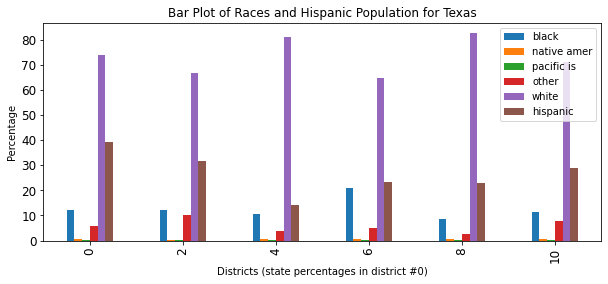

Select more districts for Texas? Y/N: 
n


In [18]:
#main code
#create empty dictionary
state_dict = {}
#build dictionary of state abbrevations, names and numbers
build_state_dict('./data/state_table.txt')
#pp(state_dict)

#prompt for state abbrevation and return state number used in census call
state_number, state_cd, state_name = state_abbrev()
#print('state_number', state_number)

#call census API with state_number
district_data, state_data = get_population(state_number)
#print(census_data)

#legend_names, names, bar1_list, bar2_list, y_pos,bar1h_list, bar2h_list, namesh = build_census_dict(census_data, state_cd)
#census_df = build_census_dict(census_data, state_cd)
#build dictionary with district data
district_dict = build_census_dict(district_data, state_cd)

district_names = list(district_dict.keys())
district_names.sort()
    
district_values = list(district_dict.values())

#build dictionary with stare data
state_dict = build_census_dict_st(state_data, state_cd)
state_values = list(state_dict.values())

#build a list of lists based on the state data    
state_lists = lists_from_dictionary_3(state_values)

#build dataframe for districts
state_df = build_df(state_lists)

#build a list of lists based on the selected disticts    
district_lists = lists_from_dictionary_3(district_values)   

#build dataframe for districts
district_df = build_df(district_lists)

#build dataframe for state
census_df = pd.concat([state_df,district_df])

#add percentages to dataframe
census2_df = percentages_df(census_df)

#Create the db connection and cursor
dbconn, cursor = connect_SQLiteDB()

table_name = 'districts_for_' + state_cd
#Create a table in the database
dbconn = create_Table(dbconn, cursor,table_name)
    
#insert census_df
dbconn = write_sql(dbconn, census2_df,table_name)

#Close the DB connection and cursor
close_DB_Resources(dbconn, cursor)

more_districts = True
while more_districts:
    #prompt for which districts to be selected
    selected_districts = select_districts(district_names)
        
    #build a list of lists based on the selected disticts    
    district_lists = lists_from_dictionary_2(district_values,selected_districts)   

    #build dataframe for districts
    district_df = build_df(district_lists)

    census_df = pd.concat([state_df,district_df])
    #print('merged')
    #print(census_df)

    #add percentages to dataframe
    census2_df = percentages_df(census_df)

    #save for SQL
    census_sql_df = census2_df
    
    plot_title = 'Bar Plot of Races and Hispanic Population for ' + state_name

    # Plot line chart including average, minimum and maximum temperature
    census2_df.plot.bar(y=['black', 'native amer', 'pacific is', 'other','white','hispanic'],
        x='district',    
        figsize=(10,4), # Figsize to make the plot larger
        title= plot_title, # Adding a title to the top
        xlabel="Districts (state percentages in district #0)", # Adding a label on the xaxis
        ylabel="Percentage", # Adding a label on y axis
        fontsize='large', # Making my ticks a bit bigger
        legend='upper center' );#legend location

    plt.show()

    #Main_loop
    not_validiated = True
    while not_validiated:
        input_anwser = input(f'Select more districts for {state_name}? Y/N: \n')
        input_anwser_u = input_anwser.upper()
        if input_anwser_u in ('Y', 'N'): 
            not_validiated = False
        else:
            print('Not valid input, please try again')           
      
    if input_anwser_u == 'N':
        more_districts = False


In [19]:
#main loop


In [20]:
print(census2_df)


  state  district     total   #black  #native amer   #asian  #pacific is  \
0    TX         0  28260856  3428211        141425  1357273        25292   
0    TX         2    794851    98199          2957    60844          860   
1    TX         4    751164    79089          5441     9076          467   
2    TX         6    785330   166182          4305    37538         1985   
3    TX         8    858427    73711          4147    26090          357   
4    TX        10    875936    99451          4405    51645          422   

    #other    #white  #hispanic  black  native amer  pacific is  other  white  \
0  1643869  20903375   11116881  12.13         0.50        0.09   5.82  73.97   
0    79804    529837     251795  12.35         0.37        0.11  10.04  66.66   
1    27286    608969     106933  10.53         0.72        0.06   3.63  81.07   
2    39278    508690     184360  21.16         0.55        0.25   5.00  64.77   
3    22542    709269     197063   8.59         0.48        0.0